In [1]:
import sys
import subprocess
import re
import os
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cmath
import operator
import random
from operator import itemgetter, attrgetter
import matplotlib.cm as cm
import vtk

## import MI measures
from mi_functions import *

In [2]:
###isabel
file1 = '../Data/Isabel_vti/isabel_p_25.vti'
file2 = '../Data/Isabel_vti/isabel_vel_25.vti'
#file2 = '../Data/Isabel_vti/isabel_qva_25.vti'
# file1 = '../Data/Isabel_vti/isabel_precip_25.vti'
# file2 = '../Data/Isabel_vti/isabel_qgraup_25.vti'
arrayName1 = 'Pressure'
arrayName2 = 'Velocity'
data_set = 'isabel'
samp_type = 'pmi' # random, pmi
pmi_power = 5 ## P & Vel = 5, P & QVA = 7


# ### Asteroid
# file1 = '../Data/Asteroid/tev.vti'
# file2 = '../Data/Asteroid/v02.vti'
# arrayName1 = 'tev'
# arrayName2 = 'v02'
# data_set = 'asteroid'
# samp_type = 'random' # random, pmi
# pmi_power = 12


# ### Combustion
# file1 = '../Data/Combustion/combustion_mixfrac.vti'
# file2 = '../Data/Combustion/combustion_Y_OH.vti'
# arrayName1 = 'mixfrac'
# arrayName2 = 'Y_OH'
# data_set = 'combustion'
# samp_type = 'random' # random, pmi
# pmi_power = 7

# ### Nyx
# file1 = '../Data/Nyx/density_1.vti'
# file2 = '../Data/Nyx/temperature_1.vti'
# arrayName1 = 'logField'
# arrayName2 = 'logField'
# data_set = 'nyx'
# samp_type = 'pmi' # random, pmi
# pmi_power = 10

totPercentage = 5
numBins=256

In [3]:
# ## load vti data
R1 = vtk.vtkXMLImageDataReader()
R1.SetFileName(file1)
R1.Update()
dataArray1 = R1.GetOutput().GetPointData().GetArray(arrayName1)

R2 = vtk.vtkXMLImageDataReader()
R2.SetFileName(file2)
R2.Update()
dataArray2 = R2.GetOutput().GetPointData().GetArray(arrayName2)

var1=np.zeros(dataArray1.GetNumberOfTuples()) 
var2=np.zeros(dataArray2.GetNumberOfTuples()) 

for i in range(dataArray1.GetNumberOfTuples()):
    var1[i] = dataArray1.GetTuple1(i)
    var2[i] = dataArray2.GetTuple1(i)

dims = R1.GetOutput().GetDimensions()

min_var1 = np.min(var1)
max_var1 = np.max(var1)

min_var2 = np.min(var2)
max_var2 = np.max(var2)

print R1.GetOutput().GetSpacing()
print R1.GetOutput().GetOrigin()

(1.0, 1.0, 1.0)
(0.0, 0.0, 0.0)


In [4]:
if samp_type == 'pmi':
    mixinig_factor_PMI = 1
elif samp_type == 'random':
    mixinig_factor_PMI = 0
    
percentageToStroe = totPercentage*mixinig_factor_PMI
percentage_rand = totPercentage*(1-mixinig_factor_PMI)
pointsToretain = int((len(var1)*percentageToStroe)/100.00)
print 'Percentage needed: ' + str(totPercentage)
print 'Points to be taken PMI based: ' + str(pointsToretain)
print 'Points to be taken randomly: ' + str(int((len(var1)*percentage_rand)/100.00))


outfile = '../output/' + str(numBins) + '_joint_'+samp_type+'_sampled_'+data_set+'_'+arrayName1+'_'+arrayName2+'_'+str(totPercentage)+'.vtp'
#outfile = '../output/joint_'+samp_type+'_sampled_'+data_set+'_'+arrayName1+'_'+arrayName2+'_'+str(totPercentage)+'.vtp'
pmivol_file = '../output/pmi_vol_mixfrac_Y_OH.vti'

Percentage needed: 5
Points to be taken PMI based: 156250
Points to be taken randomly: 0


In [5]:
## write PMI vol out
def write_PMI_vol(PMI,data1,data2,arrayName1,arrayName2,pmivol_file):
    
    dims = data1.GetDimensions()
    
    numBins = len(PMI)
    
    min_var1 = np.min(data1.GetPointData().GetArray(arrayName1))
    max_var1 = np.max(data1.GetPointData().GetArray(arrayName1))

    min_var2 = np.min(data2.GetPointData().GetArray(arrayName2))
    max_var2 = np.max(data2.GetPointData().GetArray(arrayName2))
    
    out_data = vtk.vtkImageData()
    out_data.SetDimensions(dims)
    out_data.SetSpacing(data1.GetSpacing())
    out_data.SetOrigin(data1.GetOrigin())
    
    pmiArr = vtk.vtkDoubleArray()
    pmiArr.SetName('pmi_field')
    pmiArr.SetNumberOfTuples(dims[0]*dims[1]*dims[2])
    
    index=0
    for i in range(dims[2]):
        for j in range(dims[1]):
            for k in range(dims[0]):
                
                val1 = data1.GetPointData().GetArray(arrayName1).GetTuple1(index)
                val2 = data2.GetPointData().GetArray(arrayName2).GetTuple1(index)
                
                bin_id1 = int(((val1 - min_var1)/(max_var1-min_var1))*(numBins-1))
                bin_id2 = int(((val2 - min_var2)/(max_var2-min_var2))*(numBins-1))
                
                pmi_val = PMI[bin_id1][bin_id2]
                pmiArr.SetTuple1(index, pmi_val)
                index=index+1
    
    out_data.GetPointData().AddArray(pmiArr)
    
    writer = vtk.vtkXMLImageDataWriter()
    writer.SetFileName(pmivol_file)
    writer.SetInputData(out_data)
    writer.Write()
    
###################################################################################   
## Replaces PMI = 0 values with nan just for plotting purposes
def zero_to_nan(PMI_plotting,numBins):
    for i in range(numBins):
        for j in range(numBins):
            if PMI_plotting[i][j] == 0.0:
                PMI_plotting[i][j] = float('nan')
    return PMI_plotting

## Plots the 2D PMI matrix: X axis is var1, y axis is var2
def plot_PMI_matrix(PMI):
    PMI_plotting = np.zeros_like(PMI)
    for i in range(numBins):
            for j in range(numBins):
                PMI_plotting[i][j] = PMI[i][j]
    
    zero_to_nan(PMI_plotting,numBins)
    PMI_plotting_T = PMI_plotting.T
    
    plt.figure(figsize = (6,6))
    
    plt.imshow(PMI_plotting_T,cmap='RdBu_r',origin='lower',alpha=1)
    
#     plt.tick_params(
#     axis='x',          
#     which='both',      
#     bottom=False,      
#     top=False,        
#     labelbottom=False)
    
    plt.suptitle('PMI Plot', fontsize=20)
    
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    plt.xlabel(arrayName1, fontsize=18)
    plt.ylabel(arrayName2, fontsize=18)
    #plt.colorbar()
    
    fname = 'Isabel_pmi_plot_P_VEL_' + str(numBins) + '.png' 
    #fname = 'Combustion_pmi_plot_mixfrac_Y_OH_' + str(numBins) + '.png'
    #fname = 'Asteroid_pmi_plot_tev_v02_' + str(numBins) + '.png'
    plt.savefig(fname,dpi=300)

min pmi: -7.089910748038913
max pmi: 14.0996913281325


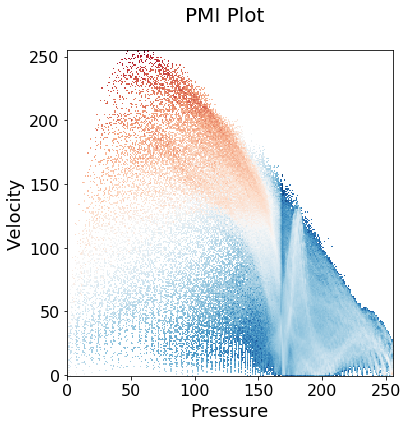

In [6]:
## Compute histogram and PMI

numSamples = np.shape(var1)[0]

hist1 = np.histogram(var1,bins=numBins)
hist2 = np.histogram(var2,bins=numBins)
hist2D = np.histogram2d(var1,var2,bins=numBins)

Array1 = hist1[0]
Array2 = hist2[0]
ArrayComb = hist2D[0]

## compute PMI
PMI = compute_pointwise_mutual_information(Array1,Array2,ArrayComb,numSamples,numBins)

# write the pmi volume out
#write_PMI_vol(PMI,R1.GetOutput(),R2.GetOutput(),arrayName1,arrayName2,pmivol_file)    

## plot 2D PMI matrix ignoring the zeroes
plot_PMI_matrix(PMI)

#PMI = -PMI
#PMI = abs(PMI)

max_pmi = np.max(PMI)
min_pmi = np.min(PMI)
print 'min pmi: ' + str(min_pmi)
print 'max pmi: ' + str(max_pmi)

# normalize PMI
PMI = (PMI-min_pmi)/(max_pmi-min_pmi)
max_pmi = np.max(PMI)
min_pmi = np.min(PMI)

###################################################################################
#################################################
PMI = np.power(PMI,pmi_power) ####

In [7]:
def compute_3d_to_1d_map (pts, dims):
    return pts[0] + dims[0]*(pts[1]+dims[1]*pts[2])


######################################################################
def sample_pmi_based(PMI,data1,data2,arrayName1,arrayName2):
    
    numBins = len(PMI[0])
    
    numPts = data1.GetPointData().GetArray(arrayName1).GetNumberOfTuples()
    dataArr1 = data1.GetPointData().GetArray(arrayName1)
    dataArr2 = data2.GetPointData().GetArray(arrayName2)
    
    range_vals1 = dataArr1.GetRange() 
    range_vals2 = dataArr2.GetRange()
    
    pdata = vtk.vtkPolyData()
    pts_arr = vtk.vtkPoints()
    sampled_arr = vtk.vtkDoubleArray()
    sampled_arr.SetName(arrayName1)
    
    sampled_arr1 = vtk.vtkDoubleArray()
    sampled_arr1.SetName(arrayName2)
    
    for i in range(numPts):
        randval = random.uniform(0, 1)
        
        dataval1 = dataArr1.GetTuple1(i)
        bin_id1 = int(((dataval1 - range_vals1[0])/(range_vals1[1]-range_vals1[0]))*(numBins-1))
        
        dataval2 = dataArr2.GetTuple1(i)
        bin_id2 = int(((dataval2 - range_vals2[0])/(range_vals2[1]-range_vals2[0]))*(numBins-1))
        
        if randval <= PMI[bin_id1][bin_id2]:
            pts_arr.InsertNextPoint(data1.GetPoint(i))
            sampled_arr.InsertNextTuple1(dataval1)
            sampled_arr1.InsertNextTuple1(dataval2)
    
    pdata.SetPoints(pts_arr)
    pdata.GetPointData().AddArray(sampled_arr)
    pdata.GetPointData().AddArray(sampled_arr1)
    
    return pdata

####################################################################
def insert_corner_pts(data,arrayName1,data1,arrayName2,sampled_data):
    
    dims = data.GetDimensions()
    varArr = data.GetPointData().GetArray(arrayName1)
    varArr1 = data1.GetPointData().GetArray(arrayName2)
    
    pts = [0,0,0]
    idx = compute_3d_to_1d_map(pts,dims)
    pts = data.GetPoint(idx)
    var_val = varArr.GetTuple1(idx)
    var_val1 = varArr1.GetTuple1(idx)
    sampled_data.GetPoints().InsertNextPoint(pts)
    sampled_data.GetPointData().GetArray(arrayName1).InsertNextTuple1(var_val)
    sampled_data.GetPointData().GetArray(arrayName2).InsertNextTuple1(var_val1)
    
    pts = [0,dims[1]-1,0]
    idx = compute_3d_to_1d_map(pts,dims)
    pts = data.GetPoint(idx)
    var_val = varArr.GetTuple1(idx)
    var_val1 = varArr1.GetTuple1(idx)
    sampled_data.GetPoints().InsertNextPoint(pts)
    sampled_data.GetPointData().GetArray(arrayName1).InsertNextTuple1(var_val)
    sampled_data.GetPointData().GetArray(arrayName2).InsertNextTuple1(var_val1)
    
    pts = [0,0,dims[2]-1]
    idx = compute_3d_to_1d_map(pts,dims)
    pts = data.GetPoint(idx)
    var_val = varArr.GetTuple1(idx)
    var_val1 = varArr1.GetTuple1(idx)
    sampled_data.GetPoints().InsertNextPoint(pts)
    sampled_data.GetPointData().GetArray(arrayName1).InsertNextTuple1(var_val)
    sampled_data.GetPointData().GetArray(arrayName2).InsertNextTuple1(var_val1)
    
    pts = [0,dims[1]-1,dims[2]-1]
    idx = compute_3d_to_1d_map(pts,dims)
    pts = data.GetPoint(idx)
    var_val = varArr.GetTuple1(idx)
    var_val1 = varArr1.GetTuple1(idx)
    sampled_data.GetPoints().InsertNextPoint(pts)
    sampled_data.GetPointData().GetArray(arrayName1).InsertNextTuple1(var_val)
    sampled_data.GetPointData().GetArray(arrayName2).InsertNextTuple1(var_val1)
    
    pts = [dims[0]-1,0,0]
    idx = compute_3d_to_1d_map(pts,dims)
    pts = data.GetPoint(idx)
    var_val = varArr.GetTuple1(idx)
    var_val1 = varArr1.GetTuple1(idx)
    sampled_data.GetPoints().InsertNextPoint(pts)
    sampled_data.GetPointData().GetArray(arrayName1).InsertNextTuple1(var_val)
    sampled_data.GetPointData().GetArray(arrayName2).InsertNextTuple1(var_val1)
    
    pts = [dims[0]-1,dims[1]-1,0]
    idx = compute_3d_to_1d_map(pts,dims)
    pts = data.GetPoint(idx)
    var_val = varArr.GetTuple1(idx)
    var_val1 = varArr1.GetTuple1(idx)
    sampled_data.GetPoints().InsertNextPoint(pts)
    sampled_data.GetPointData().GetArray(arrayName1).InsertNextTuple1(var_val)
    sampled_data.GetPointData().GetArray(arrayName2).InsertNextTuple1(var_val1)
    
    pts = [dims[0]-1,0,dims[2]-1]
    idx = compute_3d_to_1d_map(pts,dims)
    pts = data.GetPoint(idx)
    var_val = varArr.GetTuple1(idx)
    var_val1 = varArr1.GetTuple1(idx)
    sampled_data.GetPoints().InsertNextPoint(pts)
    sampled_data.GetPointData().GetArray(arrayName1).InsertNextTuple1(var_val)
    sampled_data.GetPointData().GetArray(arrayName2).InsertNextTuple1(var_val1)
    
    pts = [dims[0]-1,dims[1]-1,dims[2]-1]
    idx = compute_3d_to_1d_map(pts,dims)
    pts = data.GetPoint(idx)
    var_val = varArr.GetTuple1(idx)
    var_val1 = varArr1.GetTuple1(idx)
    sampled_data.GetPoints().InsertNextPoint(pts)
    sampled_data.GetPointData().GetArray(arrayName1).InsertNextTuple1(var_val)
    sampled_data.GetPointData().GetArray(arrayName2).InsertNextTuple1(var_val1)
    
    return sampled_data

######################################################################
def sample_random(data,arrayName1,data1,arrayName2,percentage,sampled_data):
    
    totPts = data.GetNumberOfPoints()
    varArr = data.GetPointData().GetArray(arrayName1)
    varArr1 = data1.GetPointData().GetArray(arrayName2)
    numOfPtsNeeded = int((totPts*percentage)/100.0)
    
    print 'Number of randomly selected points: ' + str(numOfPtsNeeded)
    
    rand_ids = np.random.randint(totPts, size=numOfPtsNeeded)
    
    for i in range(len(rand_ids)):
        pts = data.GetPoint(rand_ids[i])
        var_val = varArr.GetTuple1(rand_ids[i])
        var_val1 = varArr1.GetTuple1(rand_ids[i])
        
        sampled_data.GetPoints().InsertNextPoint(pts)
        sampled_data.GetPointData().GetArray(arrayName1).InsertNextTuple1(var_val)
        sampled_data.GetPointData().GetArray(arrayName2).InsertNextTuple1(var_val1)
        
    return sampled_data

######################################################################
def write_vtp(filename,pdata):
    pdatawriter = vtk.vtkXMLPolyDataWriter()
    pdatawriter.SetFileName(filename)
    pdatawriter.SetInputData(pdata)
    pdatawriter.Write()

In [8]:
ptsToCome = np.sum(PMI*ArrayComb)
print int(ptsToCome)

if ptsToCome < pointsToretain:
    fraction = pointsToretain/float(ptsToCome)
    PMI_mod = PMI*fraction
else:
    fraction = ptsToCome/float(pointsToretain)
    PMI_mod = PMI/fraction
    
print 'fraction: ' + str(fraction)

ptsToCome = np.sum(PMI_mod*ArrayComb)
print int(ptsToCome)

21532
fraction: 7.25641697871
156250


In [9]:
## Sample based on importance function
sampled_data = sample_pmi_based(PMI_mod,R1.GetOutput(),R2.GetOutput(),arrayName1,arrayName2)

percentagePickedPMI = 100*(sampled_data.GetNumberOfPoints()/float(len(var1)))
percentage_diff = (totPercentage - percentagePickedPMI)

print 'Percentage_diff: ' + str(percentage_diff)
if percentage_diff > 0:
    sampled_data_mixed = sample_random(R1.GetOutput(),arrayName1,R2.GetOutput(),arrayName2,percentage_diff,sampled_data)
    
else:
    sampled_data_mixed = sample_random(R1.GetOutput(),arrayName1,R2.GetOutput(),arrayName2,percentage_rand,sampled_data)
    
## add random sampled points
#sampled_data_mixed = sample_random(R1.GetOutput(),arrayName1,R2.GetOutput(),arrayName2,percentage_rand,sampled_data)

## add the 8 corner points for linear interpolation to work
sampled_data_final = insert_corner_pts(R1.GetOutput(),arrayName1,R2.GetOutput(),arrayName2,sampled_data_mixed)

Percentage_diff: 0.287424
Number of randomly selected points: 8981


In [10]:
print 'Final number of sampled points picked is: '+str(sampled_data_final.GetNumberOfPoints())+' and percentage: '+ \
str(100*(sampled_data_final.GetNumberOfPoints()/float(len(var1))))

## write the data out
print outfile
write_vtp(outfile,sampled_data_final)

Final number of sampled points picked is: 156257 and percentage: 5.000224
../output/256_joint_pmi_sampled_isabel_Pressure_Velocity_5.vtp
